In [3]:
from langchain_openai import ChatOpenAI
from typing import Annotated,TypedDict
from langgraph.graph.message import add_messages
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph,START,END
from langgraph.checkpoint.memory import MemorySaver



In [4]:
# state 생성
class State(TypedDict):
    messages : Annotated[list,add_messages]

# llm 생성
llm = ChatOpenAI(model="gpt-4.1-mini",temperature=0)

# 도구 생성
tool = TavilySearch()
tools=[tool]
tool_node = ToolNode(tools)
llm_with_tools = llm.bind_tools(tools)

# 노드 생성
def chatbot(state):
    return State({'messages': [llm_with_tools.invoke(state['messages'])]})

# 그래프 생성
state_graph = StateGraph(State)

state_graph.add_node('chatbot',chatbot)
state_graph.add_node('tools',tool_node)

state_graph.add_edge(START,'chatbot')
state_graph.add_conditional_edges(
    source='chatbot',
    path=tools_condition
)
state_graph.add_edge('tools','chatbot')
state_graph.add_edge('chatbot',END)


In [5]:
# 메모리 저장소 생성
graph = state_graph.compile(checkpointer=MemorySaver())

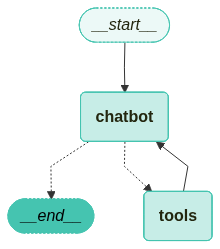

In [6]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

In [7]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "2"},  # 스레드 ID 설정
)

In [8]:
query = "2025년 하반기 행사"
for event in graph.stream({"messages": [("user", query)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_u4CjG8hUg7rPwm04Vh07NHWL)
 Call ID: call_u4CjG8hUg7rPwm04Vh07NHWL
  Args:
    query: 2025년 하반기 행사
================================= Tool Message =================================
Name: tavily_web_search

[{"url": "https://tournwine.com/entry/2025%EB%85%84-%ED%95%98%EB%B0%98%EA%B8%B0-%EB%86%93%EC%B9%98%EA%B8%B0-%EC%95%84%EA%B9%8C%EC%9A%B4-%EC%9D%8C%EC%95%85-%EC%BD%98%EC%84%9C%ED%8A%B8-%EC%B4%9D%EC%A0%95%EB%A6%AC", "title": "2025년 하반기, 놓치기 아까운 음악 콘서트 총정리 - Themed tours", "content": "이번 글에서는 화제성과 완성도를 모두 갖춘 2025년 하반기에 개최될 콘서트들을 소개한다. 1. BLACKPINK WORLD TOUR <DEADLINE>. K-POP의 글로벌 아이콘", "score": 0.852752, "raw_content": "[Themed tours](https://tournwine.com/)\n\n![블로그 이미지](https://tistory1.daumcdn.net/tistory/6848939/attach/4c105b4202b24f17a9e515e90d40ca14)\n\n# 2025년 하반기, 놓치기 아까운 음악 콘서트 총정리\n\n2025년 하반기, 대한민국은 다시 한번 음악의 열기로 뜨겁게 달아오르고 있다. 티켓 오픈과 동시에 예매 서버가 마비될 만큼 인기 가수들의 단

In [10]:
snapshot = graph.get_state(config)
snapshot.config

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09844f-6640-60c9-8003-40251c4f961a'}}

In [11]:
snapshot.values

{'messages': [HumanMessage(content='2025년 하반기 행사', additional_kwargs={}, response_metadata={}, id='f26eeb79-1dbf-48a9-a4aa-3ee058230e55'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r5iAlCIagR96V311iVJqx5hD', 'function': {'arguments': '{"query":"2025년 하반기 행사"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 98, 'total_tokens': 121, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6d7dcc9a98', 'id': 'chatcmpl-CIqcfsmVSm8DmR1uxeFJjV52zH6CK', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e29089fc-01e4-450d-aa75-1926f8d48ee4-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '2025년 하반기 행사'},

In [12]:
snapshot.next

()

In [14]:
from langchain_teddynote.messages import display_message_tree

# 메타데이터(tree 형태로 출력)
display_message_tree(snapshot.metadata)

    source: "loop"
    step: 3
    parents: {}
